In [8]:
import pandas as pd
import numpy as np
from scipy import stats


In [34]:
#Cleaning CDI Data
CDI_raw = pd.read_csv("/Users/abbyhultquist/Documents/First Year Project/CDI_results_raw_3sess.csv")

CDI = CDI_raw.copy()

print("Initial CDI shape:", CDI.shape)
CDI = CDI.sort_values(['child_id', 'session num'])
print("# of children", CDI['child_id'].nunique())

Initial CDI shape: (999, 696)
# of children 186


In [35]:
#creating a list of ALL words 
word_cols = CDI.columns[20:].tolist()
metadata_cols = CDI.columns[:20].tolist()
print("total # words considered:", len(word_cols))


total # words considered: 676


In [36]:
#converting known words to binary (1 if known, 0 if not)

CDI[word_cols] = CDI[word_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
CDI[word_cols] = (CDI[word_cols] >= 1).astype(int)

# Recompute vocab counts with binary values
CDI['vocab_size'] = CDI[word_cols].sum(axis=1)

print("num words considered  =", len(word_cols))
print("max vocab_size =", CDI['vocab_size'].max())

# Calculate initial average vocab_size
from matplotlib.pylab import mean
CDI['vocab_size'] = CDI[word_cols].sum(axis=1)
print(mean(CDI['vocab_size'])) #going to use vocab size over words spoken for now

num words considered  = 676
max vocab_size = 676
263.975975975976


/var/folders/8g/39xxtclx2rjbb5vxmz2wscfr0000gn/T/ipykernel_11897/849836764.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  CDI['vocab_size'] = CDI[word_cols].sum(axis=1)


In [ ]:
import numpy as np

early_session = 1 #starting point for early sessions
late_session = 6 #session to compare against for late sessions
num_sessions_ave = 2 #number of sessions to average for early sessions (e.g., 2 means average sessions 1 and 2)

percentile_threshold = 20 

CDI = CDI.sort_values(['child_id', 'session num'])
talker_dict = {}
for child_id, group in CDI.groupby('child_id'):
#between early sessions
    early = group[group['session num'].between(early_session, early_session + num_sessions_ave - 1)]
    early_vals = early['percentile']
    early_vals = early_vals[early_vals != 0]
    early_mean = early_vals.mean()
#between late sessions
    late = group[group['session num'].between(late_session, late_session + num_sessions_ave - 1)]
    late_vals = late['percentile']
    late_vals = late_vals[late_vals != 0]
    late_mean = late_vals.mean()

    # Skip if no usable data
    if np.isnan(early_mean) or np.isnan(late_mean): #removing kids that dont have data in early or late
        continue

    lt_early = early_mean < percentile_threshold 
    lt_late = late_mean < percentile_threshold

    if lt_early and lt_late: #if both early and late are below threshold, they are PLT
        talker_type = 'PLT'
    elif lt_early and not lt_late: #if early is below threshold but late is not, they are LB
        talker_type = 'LB'
    elif not lt_early and not lt_late: #if both early and late are above threshold, they are TT
        talker_type = 'TT'
    else: #if early is above threshold but late is below, they are a Faller
        talker_type = 'Faller'

    talker_dict[child_id] = talker_type

# Count from dictionary
counts = pd.Series(talker_dict).value_counts()
print(counts)
print("Total classified:", counts.sum())

CDI['Talker_Type'] = CDI['child_id'].map(talker_dict)
print("Children classified:", len(talker_dict))
print("Unique children in data:", CDI['child_id'].nunique())

# Reorder columns: vocab_size and Talker_Type before word columns
ordered_cols = metadata_cols + ['vocab_size', 'Talker_Type'] + word_cols
ordered_cols = [c for c in ordered_cols if c in CDI.columns]
# remove duplicates while preserving order
ordered_cols = list(dict.fromkeys(ordered_cols))
CDI = CDI[ordered_cols]


Series([], Name: count, dtype: int64)
Total classified: 0
Children classified: 0
Unique children in data: 186


In [32]:
CDI

,database id,child_id,study id,study,gender,age,birthday,session date,session num,total num sessions,...,will,would,and,because,but,if,so,then,vocab_size,Talker_Type
627,3905,4139,LTP102,Long-1,F,16.995398,2008/10/17,2010/03/18,1,12,...,0,0,0,0,0,0,0,0,96,NaN
165,3879,4139,LTP102,Long-1,F,28.270874,2008/10/17,2011/02/24,12,12,...,0,0,0,0,0,0,0,0,452,NaN
628,3906,4155,LTP107,Long-1,M,16.831032,2008/10/29,2010/03/25,1,12,...,0,0,0,0,0,0,0,0,63,NaN
0,3828,4155,LTP107,Long-1,M,26.462853,2008/10/29,2011/01/12,10,12,...,0,0,1,0,0,0,1,0,526,NaN
83,3855,4155,LTP107,Long-1,M,27.383300,2008/10/29,2011/02/09,11,12,...,1,0,1,1,1,1,1,1,598,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,6961,7800,BC800,book contexts,F,19.690993,2018/07/23,2020/03/13,1,3,...,0,0,0,0,0,0,0,0,99,NaN
450,6838,7809,BC809,book contexts,F,20.282709,2017/10/22,2019/07/01,1,3,...,0,0,0,0,0,0,0,0,97,NaN
451,6960,7818,BC818,book contexts,M,21.137410,2018/06/08,2020/03/12,1,3,...,0,0,0,0,0,0,0,0,143,NaN
402,6955,8030,BC030,book contexts,F,20.611440,2018/06/14,2020/03/02,1,3,...,0,0,0,0,0,0,0,0,51,NaN


In [5]:
# Find and remove outliers
outliers_sessions = set(CDI[CDI['session num'] > 12]['child_id'])
outliers_vocab = set(CDI[CDI['words spoken'] > len(word_cols)]['child_id'])
z_scores = stats.zscore(CDI['words spoken'])
outliers_zscore = set(CDI[np.abs(z_scores) > 3]['child_id'])

all_outliers = outliers_sessions | outliers_vocab | outliers_zscore

print(f"Removed {len(all_outliers)} additional outlier children:")
print(f"  - {len(outliers_sessions)} for session_num > 12")
print(f"  - {len(outliers_vocab)} for vocab_size > # words in CDI")
print(f"  - {len(outliers_zscore)} for zscore > 3 on vocab_size")

CDI = CDI[~CDI['child_id'].isin(all_outliers)].copy()

print(f"After removing outliers: {CDI.shape}")
print("# of children", CDI['child_id'].nunique())



Removed 1 additional outlier children:
  - 1 for session_num > 12
  - 0 for vocab_size > # words in CDI
  - 0 for zscore > 3 on vocab_size
After removing outliers: (993, 707)
# of children 517


In [6]:
#Once a word is learned, it stays learned
grouped = CDI.groupby('child_id')
for child_id, group in grouped:
    group = group.sort_values('session num')
    for word in word_cols:
        # Find first session where word is known
        known_sessions = group[group[word] == 1]['session num']
        if not known_sessions.empty:
            first_known = known_sessions.min()
            # Set word as known from first_known onwards
            CDI.loc[(CDI['child_id'] == child_id) & (CDI['session num'] >= first_known), word] = 1
# Update vocab_size to reflect the cumulative knowledge
CDI['vocab_size'] = CDI[word_cols].sum(axis=1)

print()
print("After ensuring cumulative knowledge and recalculating vocab_size")
print("Updated vocab_size to match cumulative knowledge")


After ensuring cumulative knowledge and recalculating vocab_size
Updated vocab_size to match cumulative knowledge


In [36]:
# Create dataset with 2 time points per child (>= 180 days apart)
from dateutil.relativedelta import relativedelta

CDI['session_date'] = pd.to_datetime(CDI['session date'])

two_timepoints = []

for child_id in CDI['child_id'].unique():
    child_data = CDI[CDI['child_id'] == child_id].sort_values('session_date').reset_index(drop=True)
    
    if len(child_data) < 2:
        continue  # Skip if child has only 1 session
    
    # Find the first valid pair of sessions at least 180 days apart
    for i in range(len(child_data)):
        for j in range(i + 1, len(child_data)):
            date_diff = child_data.loc[j, 'session_date'] - child_data.loc[i, 'session_date']
            
            # Check if at least 180 days apart
            if date_diff.days >= 150 and date_diff.days <= 400 :
                # Add these two sessions as time point 1 and time point 2
                tp1 = child_data.iloc[i].copy()
                tp1['time_point'] = 1
                tp2 = child_data.iloc[j].copy()
                tp2['time_point'] = 2
                
                two_timepoints.append(tp1)
                two_timepoints.append(tp2)
                break
        else:
            continue
        break

# Create new dataframe with two time points
CDI_two_timepoints = pd.DataFrame(two_timepoints)

# DAYS BETWEEN: compute how many days apart each child's two sessions are
CDI_two_timepoints['days_between_tp'] = CDI_two_timepoints.groupby('child_id')['session_date'].transform(lambda x: (x.max() - x.min()).days)

print(f"Created dataset with {len(CDI_two_timepoints)} rows")
print(f"Number of children with 2 valid time points between 300 and 400 days apart: {len(CDI_two_timepoints) // 2}")
print(f"\nSample of data:")
print(CDI_two_timepoints[['child_id', 'time_point', 'session_date', 'session num', 'vocab_size', 'percentile', 'days_between_tp']].head(10))

describe_stats = CDI_two_timepoints['days_between_tp'].describe()
print("\nDays between time points stats:")
print(describe_stats)   

CDI_two_timepoints['age'].describe()

Created dataset with 254 rows
Number of children with 2 valid time points between 300 and 400 days apart: 127

Sample of data:
  child_id  time_point session_date  session num  vocab_size  percentile  \
0     4139           1   2010-03-18            1          93   63.636364   
1     4139           2   2011-02-24           12         449   29.827586   
0     4155           1   2010-03-25            1          60   58.846154   
1     4155           2   2011-01-12           10         523   79.142857   
0     4162           1   2010-02-17            1         125   99.000000   
1     4162           2   2011-02-18           10         634   94.000000   
0     4186           1   2010-04-12            1         117   64.117647   
1     4186           2   2011-02-01           10         575   77.777778   
0     4189           1   2010-04-15            1          48   15.625000   
1     4189           2   2011-01-13           10         353   16.764706   

   days_between_tp  
0              

count    254.000000
mean      22.429168
std        5.045153
min       14.628534
25%       17.389875
50%       21.909928
75%       27.144970
max       30.703485
Name: age, dtype: float64

In [37]:
#decribe age
CDI_two_timepoints['age'].describe()

#describe age of time point 1 and time point 2
CDI_two_timepoints_tp1 = CDI_two_timepoints[CDI_two_timepoints['time_point'] == 1]
CDI_two_timepoints_tp2 = CDI_two_timepoints[CDI_two_timepoints['time_point'] == 2]  
print("Time Point 1 Age Description:")
print(CDI_two_timepoints_tp1['age'].describe())
print("\nTime Point 2 Age Description:")
print(CDI_two_timepoints_tp2['age'].describe())     



Time Point 1 Age Description:
count    127.000000
mean      17.669944
std        1.662359
min       14.628534
25%       16.535174
50%       17.389875
75%       18.967784
max       22.945431
Name: age, dtype: float64

Time Point 2 Age Description:
count    127.000000
mean      27.188391
std        1.638828
min       21.433268
25%       26.134122
50%       27.153189
75%       28.188692
max       30.703485
Name: age, dtype: float64


In [38]:
import numpy as np
import pandas as pd

# Classify based on time point 1 and time point 2 percentiles
CDI_two_timepoints['Talker_Status'] = pd.Series(dtype='string')

for child_id in CDI_two_timepoints['child_id'].unique():
    child_tp = CDI_two_timepoints[CDI_two_timepoints['child_id'] == child_id].sort_values('time_point')
    
    if len(child_tp) == 2:
        tp1_pct = child_tp[child_tp['time_point'] == 1]['percentile'].values[0]
        tp2_pct = child_tp[child_tp['time_point'] == 2]['percentile'].values[0]
        
        # Classification based on time points 1 and 2
        if tp1_pct >= 20 and tp2_pct >=18:
            status = 'TT'
        elif tp2_pct < 20 and tp1_pct < 20 :
            status = 'PLT'
        elif tp1_pct < 20 and tp2_pct >20:
            status = 'LB'
        elif tp1_pct > 20 and tp2_pct < 20:
            status = 'Faller'  
        
        CDI_two_timepoints.loc[CDI_two_timepoints['child_id'] == child_id, 'Talker_Status'] = status

print("Number of Typical Talkers:", CDI_two_timepoints[CDI_two_timepoints['Talker_Status']=='TT']['child_id'].nunique())
print("Number of Persistent Late Talkers:", CDI_two_timepoints[CDI_two_timepoints['Talker_Status']=='PLT']['child_id'].nunique())
print("Number of Late Bloomers:", CDI_two_timepoints[CDI_two_timepoints['Talker_Status']=='LB']['child_id'].nunique())

Number of Typical Talkers: 77
Number of Persistent Late Talkers: 15
Number of Late Bloomers: 33


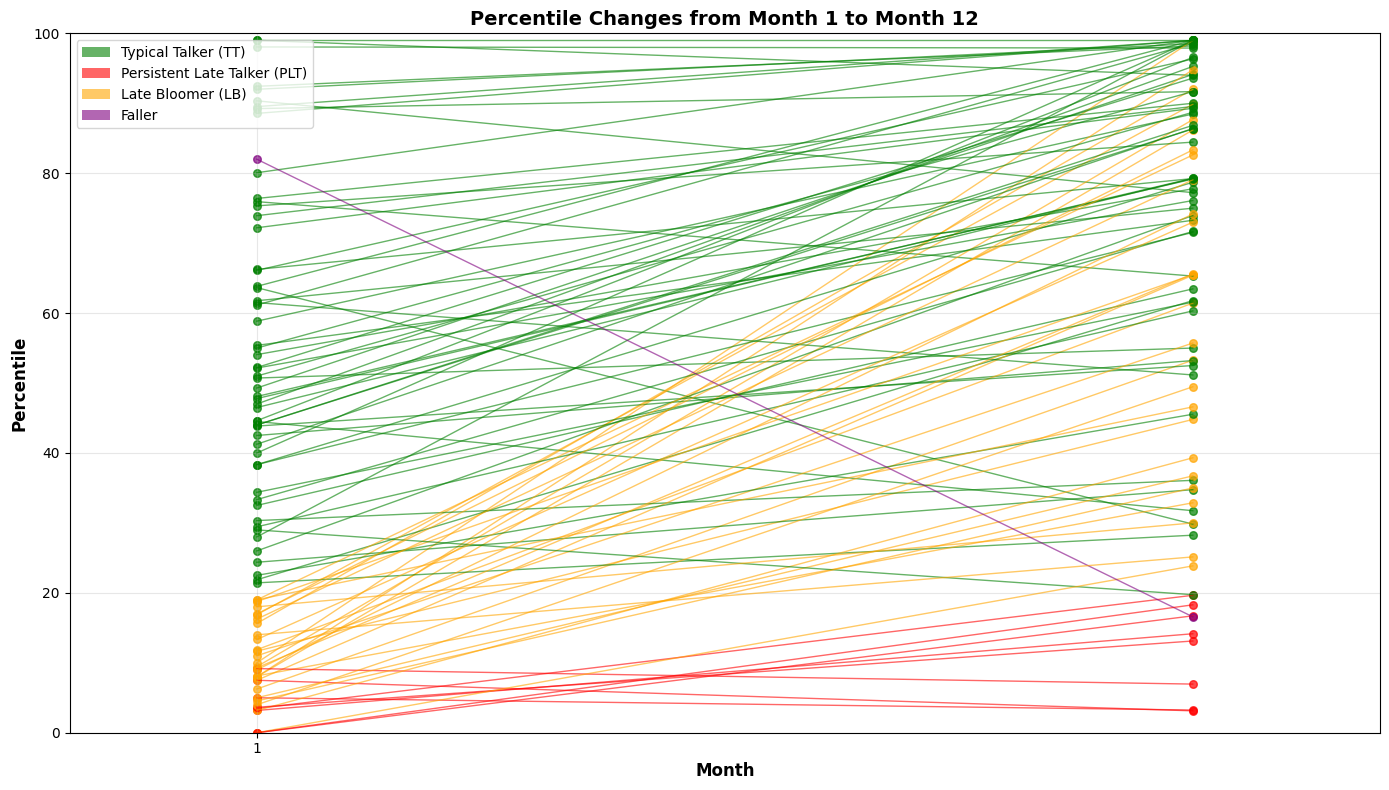

Plotted trajectories for 93 children


In [35]:
import matplotlib.pyplot as plt

# Define colors for each group
color_map = {'TT': 'green', 'PLT': 'red', 'LB': 'orange', 'Faller': "purple"}

# Create figure
fig, ax = plt.subplots(figsize=(14, 8))

# Get unique children and their status
children = CDI_two_timepoints['child_id'].unique()

# For each child, plot a line from time point 1 to time point 2
for child_id in children:
    child_tp = CDI_two_timepoints[CDI_two_timepoints['child_id'] == child_id].sort_values('time_point')
    
    if len(child_tp) == 2:
        tp1_percentile = child_tp[child_tp['time_point'] == 1]['percentile'].values[0]
        tp2_percentile = child_tp[child_tp['time_point'] == 2]['percentile'].values[0]
        status = child_tp['Talker_Status'].iloc[0]
        
        # Plot line connecting the two time points
        ax.plot([1, 2], [tp1_percentile, tp2_percentile], 
                color=color_map[status], alpha=0.6, linewidth=1)
        
        # Plot points for each time point
        ax.scatter([1], [tp1_percentile], color=color_map[status], s=30, alpha=0.7)
        ax.scatter([2], [tp2_percentile], color=color_map[status], s=30, alpha=0.7)

# Customize plot
ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentile', fontsize=12, fontweight='bold')
ax.set_title('Percentile Changes from Month 1 to Month 12', 
             fontsize=14, fontweight='bold')
ax.set_xticks([1, 12])
ax.set_xlim(0.8, 2.2)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.6, label='Typical Talker (TT)'),
    Patch(facecolor='red', alpha=0.6, label='Persistent Late Talker (PLT)'),
    Patch(facecolor='orange', alpha=0.6, label='Late Bloomer (LB)'),
    Patch(facecolor='purple', alpha=0.6, label='Faller')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Plotted trajectories for {len(children)} children")

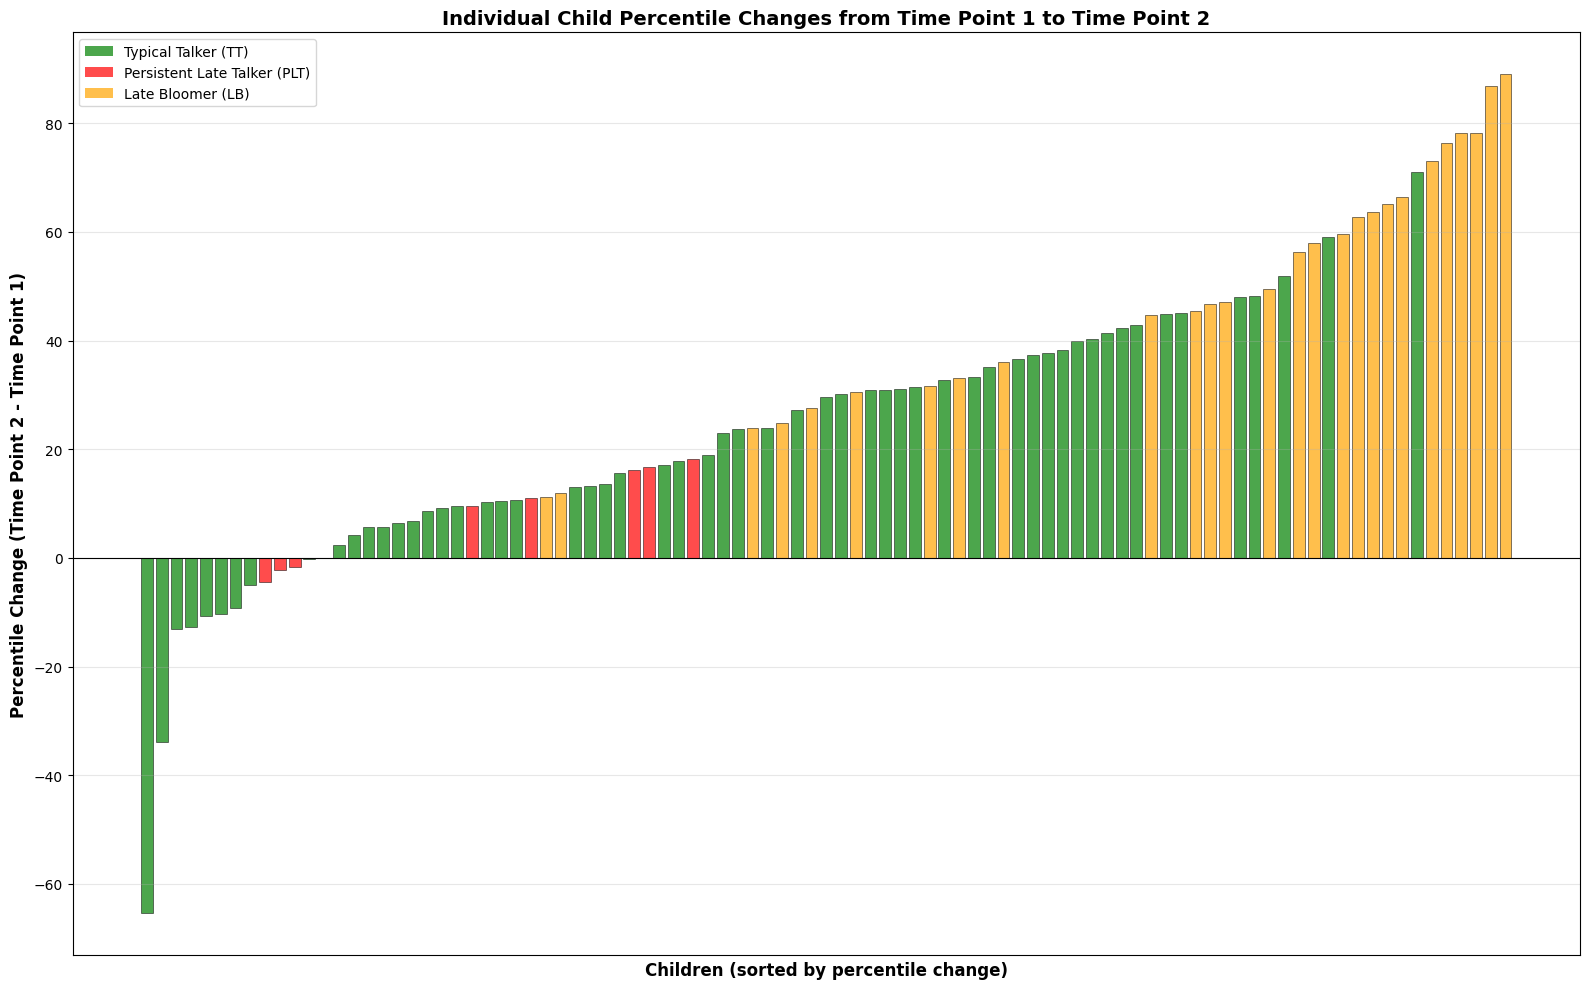


Percentile Change Summary:
Mean change: 27.83
Median change: 29.62
Min change: -65.43
Max change: 89.00

By Talker Status:
TT: Mean change = 19.78, n = 58
PLT: Mean change = 7.91, n = 8
LB: Mean change = 51.02, n = 27


In [11]:
# Calculate percentile change for each child
percentile_changes = []

for child_id in CDI_two_timepoints['child_id'].unique():
    child_tp = CDI_two_timepoints[CDI_two_timepoints['child_id'] == child_id].sort_values('time_point')
    
    if len(child_tp) == 2:
        tp1_pct = child_tp[child_tp['time_point'] == 1]['percentile'].values[0]
        tp2_pct = child_tp[child_tp['time_point'] == 2]['percentile'].values[0]
        change = tp2_pct - tp1_pct
        status = child_tp['Talker_Status'].iloc[0]
        
        percentile_changes.append({
            'child_id': child_id,
            'tp1_percentile': tp1_pct,
            'tp2_percentile': tp2_pct,
            'percentile_change': change,
            'Talker_Status': status
        })

changes_df = pd.DataFrame(percentile_changes).sort_values('percentile_change')

# Create bar chart
fig, ax = plt.subplots(figsize=(16, 10))

# Define colors
color_map = {'TT': 'green', 'PLT': 'red', 'LB': 'orange'}
colors = [color_map[status] for status in changes_df['Talker_Status']]

# Create bar chart
x_pos = range(len(changes_df))
ax.bar(x_pos, changes_df['percentile_change'], color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)

# Add horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Customize plot
ax.set_xlabel('Children (sorted by percentile change)', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentile Change (Time Point 2 - Time Point 1)', fontsize=12, fontweight='bold')
ax.set_title('Individual Child Percentile Changes from Time Point 1 to Time Point 2', 
             fontsize=14, fontweight='bold')
ax.set_xticks([])
ax.grid(True, alpha=0.3, axis='y')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='Typical Talker (TT)'),
    Patch(facecolor='red', alpha=0.7, label='Persistent Late Talker (PLT)'),
    Patch(facecolor='orange', alpha=0.7, label='Late Bloomer (LB)')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nPercentile Change Summary:")
print(f"Mean change: {changes_df['percentile_change'].mean():.2f}")
print(f"Median change: {changes_df['percentile_change'].median():.2f}")
print(f"Min change: {changes_df['percentile_change'].min():.2f}")
print(f"Max change: {changes_df['percentile_change'].max():.2f}")
print(f"\nBy Talker Status:")
for status in ['TT', 'PLT', 'LB']:
    status_data = changes_df[changes_df['Talker_Status'] == status]
    if len(status_data) > 0:
        print(f"{status}: Mean change = {status_data['percentile_change'].mean():.2f}, n = {len(status_data)}")

In [12]:
CDI_two_timepoints.to_csv("/Users/abbyhultquist/Documents/First Year Project/CDI_cleaned_2sess.csv", index=False)



In [13]:
# Build one-row-per-child summary with TP1 and TP2 values
records = []
for child_id, group in CDI_two_timepoints.groupby('child_id'):
    group = group.sort_values('time_point')
    if len(group) != 2:
        continue
    tp1 = group.iloc[0]
    tp2 = group.iloc[1]
    records.append({
        'child_id': child_id,
        'tp1_percentile': tp1['percentile'],
        'tp2_percentile': tp2['percentile'],
        'tp1_words_spoken': tp1['words spoken'] if 'words spoken' in tp1.index else tp1.get('words_spoken', None),
        'tp2_words_spoken': tp2['words spoken'] if 'words spoken' in tp2.index else tp2.get('words_spoken', None),
        'percentile_change': tp2['percentile'] - tp1['percentile'],
        'days_between_tp': int(tp1['days_between_tp']) if 'days_between_tp' in tp1.index else None,
        'Talker_Status': tp1.get('Talker_Status', '')
    })

children_summary = pd.DataFrame(records).sort_values('child_id').reset_index(drop=True)

# Show a sample and save
print("Summary (one row per child):")
print(children_summary.head())
children_summary.to_csv('/Users/abbyhultquist/Documents/First Year Project/CDI_tp1_tp2_summary.csv', index=False)
print('Saved /Users/abbyhultquist/Documents/First Year Project/CDI_tp1_tp2_summary.csv')

Summary (one row per child):
  child_id  tp1_percentile  tp2_percentile  tp1_words_spoken  \
0     4139       63.636364       29.827586                94   
1     4155       58.846154       88.461538                60   
2     4162       99.000000       94.000000               127   
3     4189       15.625000       92.000000                48   
4     4210       61.153846       98.555556               115   

   tp2_words_spoken  percentile_change  days_between_tp Talker_Status  
0               447         -33.808777              343            TT  
1               593          29.615385              321            TT  
2               633          -5.000000              366            TT  
3               656          76.375000              326            LB  
4               667          37.401709              319            TT  
Saved /Users/abbyhultquist/Documents/First Year Project/CDI_tp1_tp2_summary.csv
